In [1]:
# 1
import os
import cv2 as cv
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

2022-11-13 23:34:54.712998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 23:34:54.845562: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-13 23:34:54.886205: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 23:34:55.508878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 2
def non_trainable(model):
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
    return model

In [3]:
# 3
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    resnet = applications.ResNet50(include_top=False,weights='imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(resnet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

In [4]:
# 4
with tf.device('/device:GPU:2'):
    resnet = applications.ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3))
    resnet = non_trainable(resnet)
    fc = Flatten()(resnet.output)
    model_resnet = Model(inputs = resnet.input,outputs = fc)
    model = create_model(78,'softmax')
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])
    

2022-11-13 23:35:21.150383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 23:35:25.407750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1081 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-11-13 23:35:25.410052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1097 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-11-13 23:35:25.414228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /j

In [5]:
# 5
model.load_weights(
        "province_classification/resnet-0.951.hdf5"
    )

In [7]:
# 6
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

with tf.device('/device:GPU:2'):
    img_path = 'runs/detect/exp/crops/province/train0000002.jpg'
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

#     model = tf.keras.applications.resnet50.ResNet50()
    
    prediction = model.predict(img_preprocessed)

#     print(decode_predictions(prediction, top=3)[0])

2022-11-13 23:37:10.678610: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-13 23:37:11.495780: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-13 23:37:11.500105: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.5
2022-11-13 23:37:11.500130: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-13 23:37:11.500198: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be o

1/1 [==============================] - 4s 4s/step


In [8]:
prediction

array([[2.68633496e-02, 4.91764804e-04, 2.15045642e-03, 7.92316685e-04,
        6.96104180e-05, 9.31515358e-03, 3.02357203e-03, 1.37364725e-03,
        3.04870028e-03, 2.34801834e-03, 2.48252645e-01, 2.00047754e-02,
        3.20996670e-03, 6.30417140e-04, 6.69677393e-04, 4.28280095e-04,
        4.12610098e-04, 1.21471542e-03, 1.02800708e-02, 9.01686959e-03,
        5.34349354e-04, 1.29298316e-02, 1.06224441e-03, 2.24685557e-02,
        2.57055712e-04, 8.96294834e-04, 9.57215112e-03, 1.20825544e-02,
        2.79300497e-03, 2.25658805e-04, 6.64132356e-04, 5.11449107e-05,
        8.62369372e-04, 1.64564280e-03, 1.12864815e-04, 5.14033204e-03,
        4.65697655e-03, 8.16327811e-04, 1.63556670e-03, 1.16893824e-03,
        6.54655173e-02, 1.25063052e-05, 6.23863842e-03, 4.97615183e-05,
        4.27555442e-02, 6.35300111e-03, 7.27992097e-04, 2.98692863e-02,
        1.13804871e-02, 2.22361545e-04, 5.11368155e-04, 2.92865769e-03,
        4.19908320e-04, 4.65778983e-04, 5.39383441e-02, 5.113588

In [9]:
# 7
y_pred = np.argmax(prediction,axis=1)
y_pred

array([10])

In [11]:
list_province = ['กระบี่', 'กรุงเทพมหานคร', 'กาญจนบุรี', 'กาฬสินธุ์', 'กำแพงเพชร', 'ขอนแก่น', 'จันทบุรี', 'ฉะเชิงเทรา', 'ชลบุรี', 'ชัยนาท', 'ชัยภูมิ', 'ชุมพร', 'ตรัง', 'ตราด', 'ตาก', 'นครนายก', 'นครปฐม', 'นครพนม', 'นครราชสีมา', 'นครศรีธรรมราช', 'นครสวรรค์', 'นนทบุรี', 'นราธิวาส', 'น่าน', 'บึงกาฬ', 'บุรีรัมย์', 'ปทุมธานี', 'ประจวบคีรีขันธ์', 'ปราจีนบุรี', 'ปัตตานี', 'พระนครศรีอยุธยา', 'พะเยา', 'พังงา', 'พัทลุง', 'พิจิตร', 'พิษณุโลก', 'ภูเก็ต', 'มหาสารคาม', 'มุกดาหาร', 'ยะลา', 'ยโสธร', 'ระนอง', 'ระยอง', 'ราชบุรี', 'ร้อยเอ็ด', 'ลพบุรี', 'ลำปาง', 'ลำพูน', 'ศรีสะเกษ', 'สกลนคร', 'สงขลา', 'สตูล', 'สมุทรปราการ', 'สมุทรสงคราม', 'สมุทรสาคร', 'สระบุรี', 'สระแก้ว', 'สิงห์บุรี', 'สุพรรณบุรี', 'สุราษฎร์ธานี', 'สุรินทร์', 'สุโขทัย', 'หนองคาย', 'หนองบัวลำภู', 'อำนาจเจริญ', 'อุดรธานี', 'อุตรดิตถ์', 'อุทัยธานี', 'อุบลราชธานี', 'อ่างทอง', 'เชียงราย', 'เชียงใหม่', 'เบตง', 'เพชรบุรี', 'เพชรบูรณ์', 'เลย', 'เเพร่', 'แม่ฮ่องสอน']


In [12]:
# 8
list_province[int(y_pred) - 1]

'ชัยนาท'

### relabel

In [130]:
import pandas as pd
df = pd.read_csv('label_test.csv')
df

,filenames,เลขทะเบียน
0,1000.jpg,ฆผ1455
1,1008.jpg,3กด614
2,1011.jpg,กบ8994
3,1012.jpg,กบ8994
4,1019.jpg,ผข9104
...,...,...
430,989.jpg,5กว635
431,991.jpg,กน5033
432,995.jpg,1ฒย8194
433,998.jpg,1ฒณ2959


In [107]:
df.sort_values(by=['filenames'])

,filenames,เลขทะเบียน
0,1000.jpg,ฆผ1455
1,1008.jpg,3กด614
2,1011.jpg,กบ8994
3,1012.jpg,กบ8994
4,1019.jpg,ผข9104
...,...,...
430,989.jpg,5กว635
431,991.jpg,กน5033
432,995.jpg,1ฒย8194
433,998.jpg,1ฒณ2959


In [110]:
df1 = df.filenames.to_numpy()
# list_of_label_array = df_2._then.to_numpy()
df1.tolist()

['1000.jpg',
 '1008.jpg',
 '1011.jpg',
 '1012.jpg',
 '1019.jpg',
 '102.jpg',
 '1022.jpg',
 '1025.jpg',
 '1030.jpg',
 '1038.jpg',
 '1054.jpg',
 '1058.jpg',
 '1062.jpg',
 '1064.jpg',
 '1065.jpg',
 '1071.jpg',
 '1074.jpg',
 '1081.jpg',
 '1087.jpg',
 '1088.jpg',
 '1095.jpg',
 '1100.jpg',
 '1102.jpg',
 '111.jpg',
 '1112.jpg',
 '1114.jpg',
 '1117.jpg',
 '112.jpg',
 '1130.jpg',
 '1131.jpg',
 '1134.jpg',
 '1140.jpg',
 '1145.jpg',
 '1147.jpg',
 '1148.jpg',
 '1149.jpg',
 '115.jpg',
 '1152.jpg',
 '1159.jpg',
 '1164.jpg',
 '1165.jpg',
 '1169.jpg',
 '1172.jpg',
 '1173.jpg',
 '1174.jpg',
 '1175.jpg',
 '1176.jpg',
 '1179.jpg',
 '118.jpg',
 '1181.jpg',
 '1183.jpg',
 '1187.jpg',
 '1195.jpg',
 '1197.jpg',
 '1198.jpg',
 '1200.jpg',
 '1212.jpg',
 '1215.jpg',
 '122.jpg',
 '1223.jpg',
 '1228.jpg',
 '123.jpg',
 '1231.jpg',
 '1236.jpg',
 '1238.jpg',
 '1239.jpg',
 '1241.jpg',
 '1246.jpg',
 '1249.jpg',
 '125.jpg',
 '1251.jpg',
 '1257.jpg',
 '1259.jpg',
 '1260.jpg',
 '1262.jpg',
 '1263.jpg',
 '1268.jpg',
 '1269.

In [108]:
df_pro = pd.read_excel('label_car.xlsx')
df_pro

,filename,จังหวัด,comment
0,1.jpg,เลย,NaN
1,2.jpg,เลย,NaN
2,3.jpg,เชียงใหม่,NaN
3,4.jpg,เชียงใหม่,NaN
4,5.jpg,กรุงเทพมหานคร,NaN
...,...,...,...
1464,1814.jpg,นครนายก,รถเอียง
1465,1815.jpg,นครนายก,NaN
1466,1816.jpg,ลำพูน,NaN
1467,1817.jpg,เชียงราย,NaN


In [114]:
df_pro1 = df_pro.sort_values(by=['filename'])

In [115]:
df_pro1

,filename,จังหวัด,comment
0,1.jpg,เลย,NaN
747,1000.jpg,กรุงเทพมหานคร,NaN
748,1004.jpg,สกลนคร,ป้ายเบลอ
749,1005.jpg,สกลนคร,NaN
750,1007.jpg,กรุงเทพมหานคร,NaN
...,...,...,...
742,995.jpg,กรุงเทพมหานคร,NaN
743,996.jpg,อุบลราชธานี,NaN
744,997.jpg,อุบลราชธานี,NaN
745,998.jpg,กรุงเทพมหานคร,NaN


In [117]:
df2 = df_pro1.filename.to_numpy()
# list_of_label_array = df_2._then.to_numpy()
df2.tolist()

['1.jpg',
 '1000.jpg',
 '1004.jpg',
 '1005.jpg',
 '1007.jpg',
 '1008.jpg',
 '101.jpg',
 '1011.jpg',
 '1012.jpg',
 '1013.jpg',
 '1014.jpg',
 '1015.jpg',
 '1016.jpg',
 '1017.jpg',
 '1019.jpg',
 '102.jpg',
 '1020.jpg',
 '1022.jpg',
 '1023.jpg',
 '1024.jpg',
 '1025.jpg',
 '1028.jpg',
 '1029.jpg',
 '103.jpg',
 '1030.jpg',
 '1031.jpg',
 '1032.jpg',
 '1034.jpg',
 '1035.jpg',
 '1036.jpg',
 '1037.jpg',
 '1038.jpg',
 '104.jpg',
 '1043.jpg',
 '1044.jpg',
 '1045.jpg',
 '1046.jpg',
 '1047.jpg',
 '1048.jpg',
 '1049.jpg',
 '105.jpg',
 '1050.jpg',
 '1051.jpg',
 '1052.jpg',
 '1054.jpg',
 '1055.jpg',
 '1056.jpg',
 '1057.jpg',
 '1058.jpg',
 '1059.jpg',
 '106.jpg',
 '1060.jpg',
 '1061.jpg',
 '1062.jpg',
 '1063.jpg',
 '1064.jpg',
 '1065.jpg',
 '1066.jpg',
 '1067.jpg',
 '1068.jpg',
 '1069.jpg',
 '1070.jpg',
 '1071.jpg',
 '1073.jpg',
 '1074.jpg',
 '1075.jpg',
 '1076.jpg',
 '1079.jpg',
 '1080.jpg',
 '1081.jpg',
 '1083.jpg',
 '1084.jpg',
 '1087.jpg',
 '1088.jpg',
 '1089.jpg',
 '109.jpg',
 '1090.jpg',
 '1091.jp

In [113]:
df_pro

,filename,จังหวัด,comment
0,1.jpg,เลย,NaN
1,2.jpg,เลย,NaN
2,3.jpg,เชียงใหม่,NaN
3,4.jpg,เชียงใหม่,NaN
4,5.jpg,กรุงเทพมหานคร,NaN
...,...,...,...
1464,1814.jpg,นครนายก,รถเอียง
1465,1815.jpg,นครนายก,NaN
1466,1816.jpg,ลำพูน,NaN
1467,1817.jpg,เชียงราย,NaN


In [116]:
def intersection(lst1, lst2):
    lst_intersec = [value for value in lst1 if value in lst2]
    return lst_intersec

In [118]:
intersection(df1, df2)

['1000.jpg',
 '1008.jpg',
 '1011.jpg',
 '1012.jpg',
 '1019.jpg',
 '102.jpg',
 '1022.jpg',
 '1025.jpg',
 '1030.jpg',
 '1038.jpg',
 '1054.jpg',
 '1058.jpg',
 '1062.jpg',
 '1064.jpg',
 '1065.jpg',
 '1071.jpg',
 '1074.jpg',
 '1081.jpg',
 '1087.jpg',
 '1088.jpg',
 '1095.jpg',
 '1100.jpg',
 '1102.jpg',
 '111.jpg',
 '1112.jpg',
 '1114.jpg',
 '1117.jpg',
 '112.jpg',
 '1130.jpg',
 '1131.jpg',
 '1134.jpg',
 '1140.jpg',
 '1145.jpg',
 '1147.jpg',
 '1148.jpg',
 '1149.jpg',
 '115.jpg',
 '1152.jpg',
 '1159.jpg',
 '1164.jpg',
 '1165.jpg',
 '1169.jpg',
 '1172.jpg',
 '1173.jpg',
 '1174.jpg',
 '1175.jpg',
 '1176.jpg',
 '1179.jpg',
 '118.jpg',
 '1181.jpg',
 '1183.jpg',
 '1187.jpg',
 '1195.jpg',
 '1197.jpg',
 '1198.jpg',
 '1200.jpg',
 '1212.jpg',
 '1215.jpg',
 '122.jpg',
 '1223.jpg',
 '1228.jpg',
 '123.jpg',
 '1231.jpg',
 '1236.jpg',
 '1238.jpg',
 '1239.jpg',
 '1241.jpg',
 '1246.jpg',
 '1249.jpg',
 '125.jpg',
 '1251.jpg',
 '1257.jpg',
 '1259.jpg',
 '1260.jpg',
 '1262.jpg',
 '1263.jpg',
 '1268.jpg',
 '1269.

In [122]:
df_action

,filename,จังหวัด,comment
747,1000.jpg,กรุงเทพมหานคร,NaN
751,1008.jpg,กรุงเทพมหานคร,NaN
752,1011.jpg,พระนครศรีอยุธยา,NaN
753,1012.jpg,พระนครศรีอยุธยา,สีจาง
759,1019.jpg,อุดรธานี,NaN
...,...,...,...
739,989.jpg,กรุงเทพมหานคร,NaN
740,991.jpg,สุรินทร์,NaN
742,995.jpg,กรุงเทพมหานคร,NaN
745,998.jpg,กรุงเทพมหานคร,NaN


In [124]:
df_action1

,filenames,เลขทะเบียน
0,1000.jpg,ฆผ1455
1,1008.jpg,3กด614
2,1011.jpg,กบ8994
3,1012.jpg,กบ8994
4,1019.jpg,ผข9104
...,...,...
430,989.jpg,5กว635
431,991.jpg,กน5033
432,995.jpg,1ฒย8194
433,998.jpg,1ฒณ2959


In [138]:
df2 = df

In [139]:
df2

,filenames,เลขทะเบียน
0,1000.jpg,ฆผ1455
1,1008.jpg,3กด614
2,1011.jpg,กบ8994
3,1012.jpg,กบ8994
4,1019.jpg,ผข9104
...,...,...
430,989.jpg,5กว635
431,991.jpg,กน5033
432,995.jpg,1ฒย8194
433,998.jpg,1ฒณ2959


In [125]:
df['จังหวัด'] = df_action['จังหวัด']

In [133]:
df1 = pd.DataFrame(a)

In [128]:
df_action['จังหวัด']

747      กรุงเทพมหานคร
751      กรุงเทพมหานคร
752    พระนครศรีอยุธยา
753    พระนครศรีอยุธยา
759           อุดรธานี
            ...       
739      กรุงเทพมหานคร
740           สุรินทร์
742      กรุงเทพมหานคร
745      กรุงเทพมหานคร
746      กรุงเทพมหานคร
Name: จังหวัด, Length: 435, dtype: object

In [132]:
a = df_action['จังหวัด'].tolist()

In [135]:

df1.columns =['จังหวัด']

In [136]:
df1

,จังหวัด
0,กรุงเทพมหานคร
1,กรุงเทพมหานคร
2,พระนครศรีอยุธยา
3,พระนครศรีอยุธยา
4,อุดรธานี
...,...
430,กรุงเทพมหานคร
431,สุรินทร์
432,กรุงเทพมหานคร
433,กรุงเทพมหานคร


In [140]:
df2

,filenames,เลขทะเบียน
0,1000.jpg,ฆผ1455
1,1008.jpg,3กด614
2,1011.jpg,กบ8994
3,1012.jpg,กบ8994
4,1019.jpg,ผข9104
...,...,...
430,989.jpg,5กว635
431,991.jpg,กน5033
432,995.jpg,1ฒย8194
433,998.jpg,1ฒณ2959


In [141]:
df2['จังหวัด'] = a

In [142]:
df2

,filenames,เลขทะเบียน,จังหวัด
0,1000.jpg,ฆผ1455,กรุงเทพมหานคร
1,1008.jpg,3กด614,กรุงเทพมหานคร
2,1011.jpg,กบ8994,พระนครศรีอยุธยา
3,1012.jpg,กบ8994,พระนครศรีอยุธยา
4,1019.jpg,ผข9104,อุดรธานี
...,...,...,...
430,989.jpg,5กว635,กรุงเทพมหานคร
431,991.jpg,กน5033,สุรินทร์
432,995.jpg,1ฒย8194,กรุงเทพมหานคร
433,998.jpg,1ฒณ2959,กรุงเทพมหานคร


In [143]:
df2.to_csv('label.csv')

In [148]:
df['เลขทะเบียน'][df['filenames'] == '1000.jpg'].tolist()[0]

'ฆผ1455'

In [155]:

import time

seconds = time.time()
for i in range(4):
     
    # using sleep() to halt execution
    time.sleep(1)
    print(i)
    
end = time.time() - seconds
print(seconds)
print(end)

0
1
2
3
1668870121.2528408
4.004621982574463


### Error Analysis

In [157]:
import pandas as pd
df_test = pd.read_csv('system.csv')
df_test

,Unnamed: 0,filenames,actual register,actual province,predict register,predict province
0,0,1000.jpg,ฆผ1455,กรุงเทพมหานคร,ฆผ1455,กรุงเทพมหานคร
1,1,1008.jpg,3กด614,กรุงเทพมหานคร,3กด614,กรุงเทพมหานคร
2,2,1011.jpg,กบ8994,พระนครศรีอยุธยา,กบ8994,พระนครศรีอยุธยา
3,3,1012.jpg,กบ8994,พระนครศรีอยุธยา,กบ8994,พระนครศรีอยุธยา
4,4,1019.jpg,ผข9104,อุดรธานี,ผข9104,กระบี่
...,...,...,...,...,...,...
430,430,989.jpg,5กว635,กรุงเทพมหานคร,5กว635,กรุงเทพมหานคร
431,431,991.jpg,กน5033,สุรินทร์,กน5033,สุรินทร์
432,432,995.jpg,1ฒย8194,กรุงเทพมหานคร,1ฒย8194,กรุงเทพมหานคร
433,433,998.jpg,1ฒณ2959,กรุงเทพมหานคร,1ฒณ2959,กรุงเทพมหานคร


In [168]:
from sklearn.metrics import classification_report, confusion_matrix
y_actual = []
y_pred = []
for p in range(len(df_test)): 
    y_actual.append(df_test['actual province'][p])
    y_pred.append(df_test['predict province'][p])

In [171]:
list_province = ['กระบี่', 'กรุงเทพมหานคร', 'กาญจนบุรี', 'กาฬสินธุ์', 'กำแพงเพชร', 'ขอนแก่น', 'จันทบุรี', 'ฉะเชิงเทรา', 'ชลบุรี', 'ชัยนาท', 'ชัยภูมิ', 'ชุมพร', 'ตรัง', 'ตราด', 'ตาก', 'นครนายก', 'นครปฐม', 'นครพนม', 'นครราชสีมา', 'นครศรีธรรมราช', 'นครสวรรค์', 'นนทบุรี', 'นราธิวาส', 'น่าน', 'บึงกาฬ', 'บุรีรัมย์', 'ปทุมธานี', 'ประจวบคีรีขันธ์', 'ปราจีนบุรี', 'ปัตตานี', 'พระนครศรีอยุธยา', 'พะเยา', 'พังงา', 'พัทลุง', 'พิจิตร', 'พิษณุโลก', 'ภูเก็ต', 'มหาสารคาม', 'มุกดาหาร', 'ยะลา', 'ยโสธร', 'ระนอง', 'ระยอง', 'ราชบุรี', 'ร้อยเอ็ด', 'ลพบุรี', 'ลำปาง', 'ลำพูน', 'ศรีสะเกษ', 'สกลนคร', 'สงขลา', 'สตูล', 'สมุทรปราการ', 'สมุทรสงคราม', 'สมุทรสาคร', 'สระบุรี', 'สระแก้ว', 'สิงห์บุรี', 'สุพรรณบุรี', 'สุราษฎร์ธานี', 'สุรินทร์', 'สุโขทัย', 'หนองคาย', 'หนองบัวลำภู', 'อำนาจเจริญ', 'อุดรธานี', 'อุตรดิตถ์', 'อุทัยธานี', 'อุบลราชธานี', 'อ่างทอง', 'เชียงราย', 'เชียงใหม่', 'เบตง', 'เพชรบุรี', 'เพชรบูรณ์', 'เลย', 'เเพร่', 'แม่ฮ่องสอน']

#### round 2

In [173]:
import pandas as pd
df_test = pd.read_csv('system.csv')
df_test

,Unnamed: 0,filenames,actual register,actual province,predict register,predict province
0,0,1000.jpg,ฆผ1455,กรุงเทพมหานคร,ฆผ1455,กรุงเทพมหานคร
1,1,1008.jpg,3กด614,กรุงเทพมหานคร,3กด614,กรุงเทพมหานคร
2,2,1011.jpg,กบ8994,พระนครศรีอยุธยา,กบ8994,พระนครศรีอยุธยา
3,3,1012.jpg,กบ8994,พระนครศรีอยุธยา,กข8992,พระนครศรีอยุธยา
4,4,1019.jpg,ผข9104,อุดรธานี,ผข9104,กระบี่
...,...,...,...,...,...,...
430,430,989.jpg,5กว635,กรุงเทพมหานคร,5กว635,กรุงเทพมหานคร
431,431,991.jpg,กน5033,สุรินทร์,กน5033,สุรินทร์
432,432,995.jpg,1ฒย8194,กรุงเทพมหานคร,1ฒย8194,กรุงเทพมหานคร
433,433,998.jpg,1ฒณ2959,กรุงเทพมหานคร,1ฒณ2959,กรุงเทพมหานคร


filenames : 1012.jpg
actual register : กบ8994
predict register : กข8992


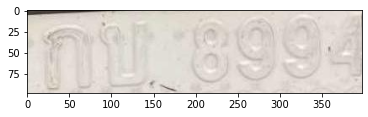

-------------------------------
filenames : 1130.jpg
actual register : ถจ6527
predict register : กจ6527


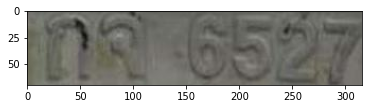

-------------------------------
filenames : 1131.jpg
actual register : กจ6527
predict register : กจ6827


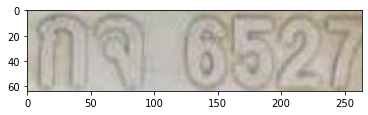

-------------------------------
filenames : 1140.jpg
actual register : 4กบ4743
predict register : 4กบ4741


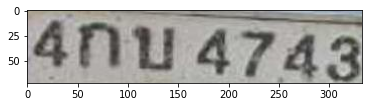

-------------------------------
filenames : 115.jpg
actual register : ฮง9455
predict register : ชง4455


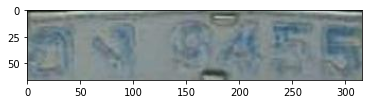

-------------------------------
filenames : 1159.jpg
actual register : กท3327
predict register : กท3227


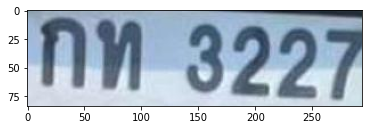

-------------------------------
filenames : 1179.jpg
actual register : ฎศ1675
predict register : กพ1675


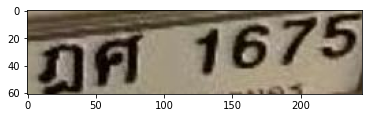

-------------------------------
filenames : 118.jpg
actual register : ปย7773
predict register : บย7773


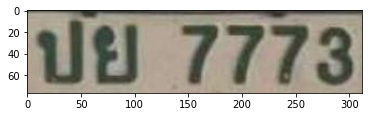

-------------------------------
filenames : 1181.jpg
actual register : ศฉ53
predict register : กฉ53


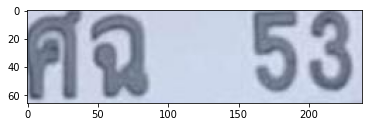

-------------------------------
filenames : 1212.jpg
actual register : ฎพ7649
predict register : ฏพ7649


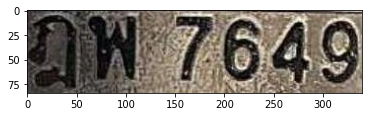

-------------------------------
filenames : 1238.jpg
actual register : ยก5152
predict register : ขก5152


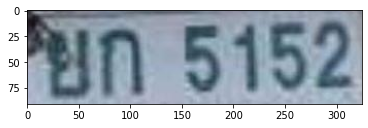

-------------------------------
filenames : 1305.jpg
actual register : 8กฐ5730
predict register : กจ5790


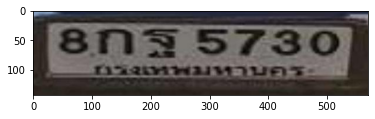

-------------------------------
filenames : 1341.jpg
actual register : ผผ2581
predict register : ผผ258ผ


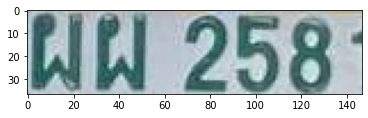

-------------------------------
filenames : 1455.jpg
actual register : ยข2043
predict register : ยช2043


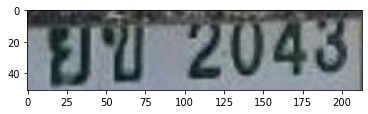

-------------------------------
filenames : 1528.jpg
actual register : กต8968
predict register : ผต8968


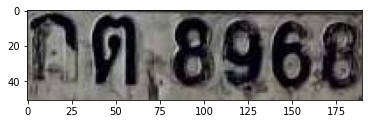

-------------------------------
filenames : 1560.jpg
actual register : 3กฬ6626
predict register : 4กฬ6626


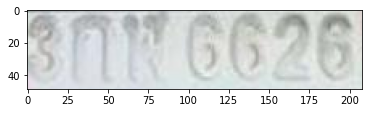

-------------------------------
filenames : 1665.jpg
actual register : บว9223
predict register : ปว9223


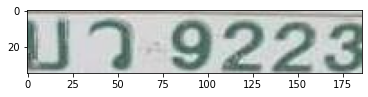

-------------------------------
filenames : 178.jpg
actual register : ถน7307
predict register : กน7397


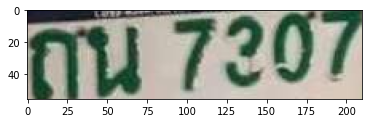

-------------------------------
filenames : 1801.jpg
actual register : กร5298
predict register : 1กร5298


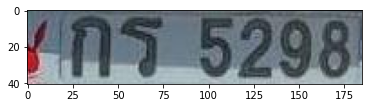

-------------------------------
filenames : 1812.jpg
actual register : 1นก468
predict register : 1กก468


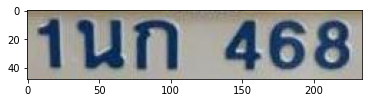

-------------------------------
filenames : 1813.jpg
actual register : บฉ3067
predict register : บอ3067


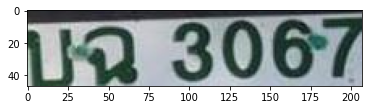

-------------------------------
filenames : 1816.jpg
actual register : บพ983
predict register : บพ981


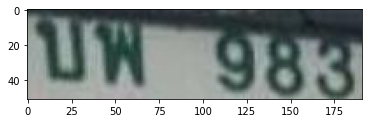

-------------------------------
filenames : 240.jpg
actual register : งค382
predict register : ผก1331


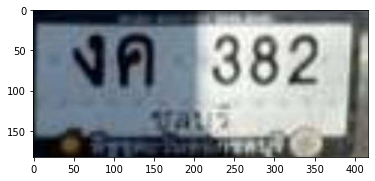

-------------------------------
filenames : 252.jpg
actual register : กค130
predict register : กค1330


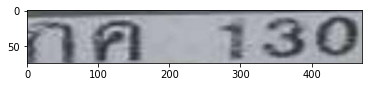

-------------------------------
filenames : 337.jpg
actual register : กค6819
predict register : กค6619


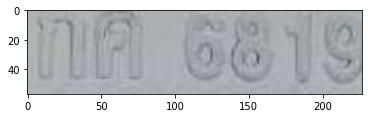

-------------------------------
filenames : 375.jpg
actual register : บบ5752
predict register : ปป3752


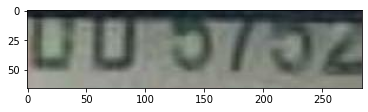

-------------------------------
filenames : 469.jpg
actual register : 2ฒฒ8782
predict register : 9ฒฒ8782


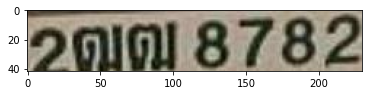

-------------------------------
filenames : 553.jpg
actual register : 1ฒช1182
predict register : 1ฒช1132


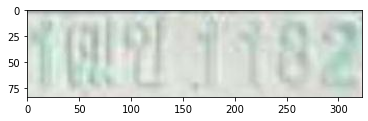

-------------------------------
filenames : 569.jpg
actual register : บม6586
predict register : บน6586


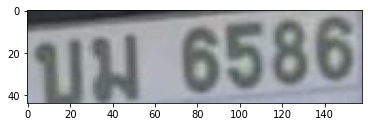

-------------------------------
filenames : 605.jpg
actual register : กน4505
predict register : กน4562


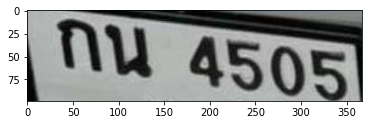

-------------------------------
filenames : 617.jpg
actual register : กจ5709
predict register : 1ฒจ5709


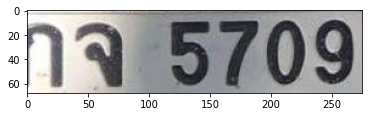

-------------------------------
filenames : 7.jpg
actual register : 1ฒฌ404
predict register : 1ฒป4004


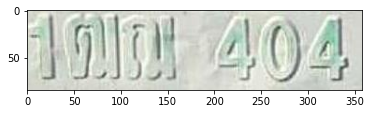

-------------------------------
filenames : 745.jpg
actual register : ษษ7744
predict register : บษ7744


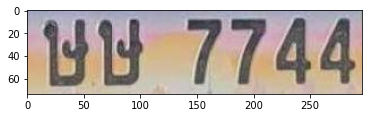

-------------------------------
filenames : 887.jpg
actual register : บต4576
predict register : บต4571


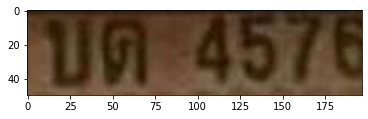

-------------------------------


In [174]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
# results_df['actual register'][0]
# results_df['predict register'][0]
# print(len(results_df))
for k in range(len(df_test)):
    if df_test['actual register'][k] != df_test['predict register'][k]:
        print('filenames :',df_test['filenames'][k])
        print('actual register :', df_test['actual register'][k])
        print('predict register :',df_test['predict register'][k])
        img = Image.open('out/register/'+df_test['filenames'][k])
        imgplot = plt.imshow(img)
        plt.show()
        print('-------------------------------')

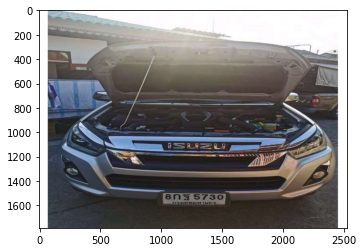

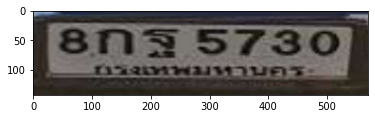

In [182]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
# http://localhost:8080/view/workplace_internship/lp_recog/Ruk/system/test/1305.jpg
img = Image.open('test/1305.jpg')
imgplot = plt.imshow(img)
plt.show()
box = (xmin, ymin, xmax, ymax)
img2 = img.crop(box)
imgplot = plt.imshow(img2)
# img2.save('../Ruk/dataset_lp_crop/test')
imgplot = plt.imshow(img2)
plt.show()

filenames : 1019.jpg
actual register : อุดรธานี
predict register : กระบี่


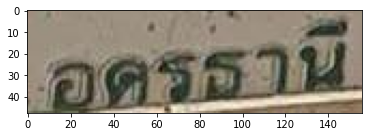

-------------------------------
filenames : 1062.jpg
actual register : ชลบุรี
predict register : ลพบุรี


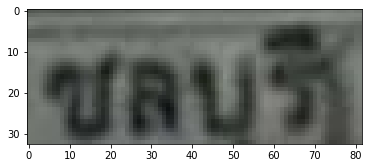

-------------------------------
filenames : 1074.jpg
actual register : ขอนแก่น
predict register : กรุงเทพมหานคร


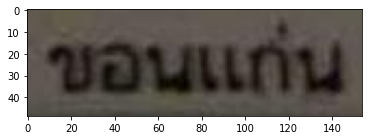

-------------------------------
filenames : 1100.jpg
actual register : กรุงเทพมหานคร
predict register : สมุทรสาคร


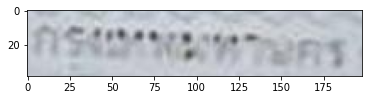

-------------------------------
filenames : 1117.jpg
actual register : นครราชสีมา
predict register : พระนครศรีอยุธยา


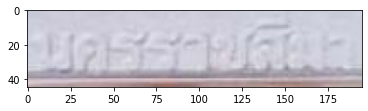

-------------------------------
filenames : 1130.jpg
actual register : ชุมพร
predict register : มหาสารคาม


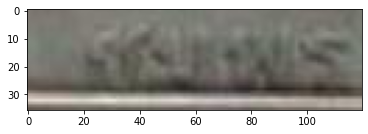

-------------------------------
filenames : 1131.jpg
actual register : ชุมพร
predict register : เพชรบุรี


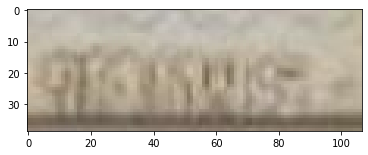

-------------------------------
filenames : 1149.jpg
actual register : เพชรบูรณ์
predict register : กรุงเทพมหานคร


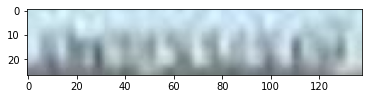

-------------------------------
filenames : 115.jpg
actual register : กรุงเทพมหานคร
predict register : สระแก้ว


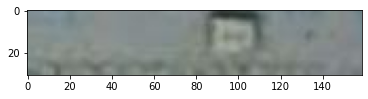

-------------------------------
filenames : 1159.jpg
actual register : เพชรบูรณ์
predict register : เพชรบุรี


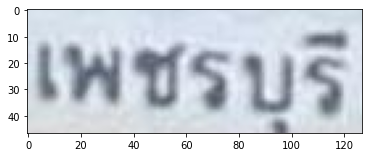

-------------------------------
filenames : 1197.jpg
actual register : ขอนแก่น
predict register : พระนครศรีอยุธยา


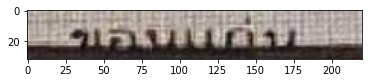

-------------------------------
filenames : 122.jpg
actual register : อุดรธานี
predict register : สงขลา


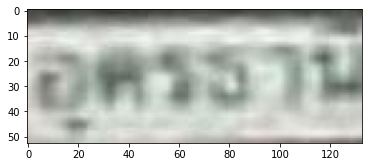

-------------------------------
filenames : 123.jpg
actual register : อุดรธานี
predict register : เพชรบุรี


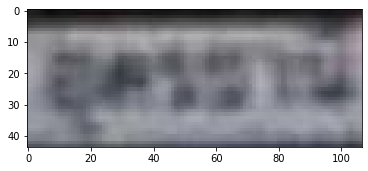

-------------------------------
filenames : 1238.jpg
actual register : นคราชสีมา
predict register : นครราชสีมา


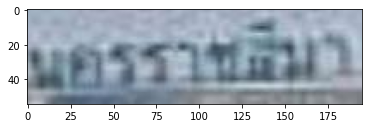

-------------------------------
filenames : 1239.jpg
actual register : นคราชสีมา
predict register : นครราชสีมา


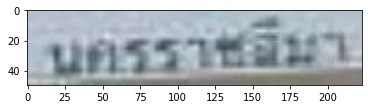

-------------------------------
filenames : 1246.jpg
actual register : ชุมพร
predict register : ชลบุรี


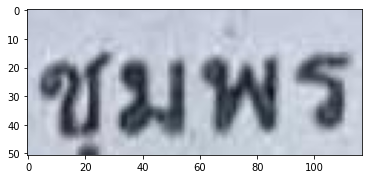

-------------------------------
filenames : 1257.jpg
actual register : ระยอง
predict register : นครพนม


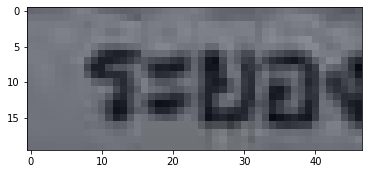

-------------------------------
filenames : 1260.jpg
actual register : เลย
predict register : พะเยา


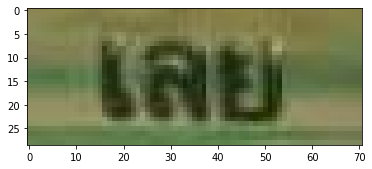

-------------------------------
filenames : 1286.jpg
actual register : นคราชสีมา
predict register : นครราชสีมา


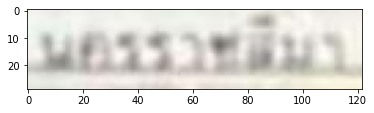

-------------------------------
filenames : 1341.jpg
actual register : ชลบุรี
predict register : นนทบุรี


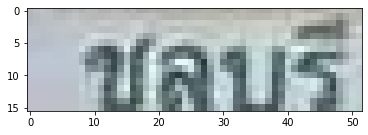

-------------------------------
filenames : 1379.jpg
actual register : กาญจนบุรี
predict register : กรุงเทพมหานคร


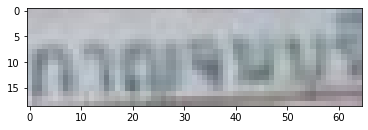

-------------------------------
filenames : 1386.jpg
actual register : กรุงเทพมหานคร
predict register : พระนครศรีอยุธยา


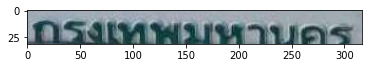

-------------------------------
filenames : 1459.jpg
actual register : พิจิตร
predict register : กรุงเทพมหานคร


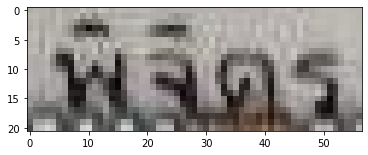

-------------------------------
filenames : 1461.jpg
actual register : อุดรธานี
predict register : นนทบุรี


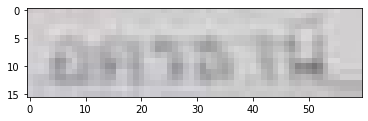

-------------------------------
filenames : 1476.jpg
actual register : กระบี่
predict register : กรุงเทพมหานคร


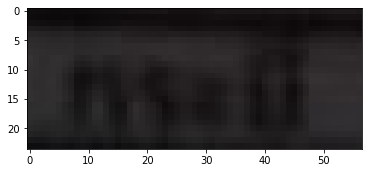

-------------------------------
filenames : 1480.jpg
actual register : ยโสธร
predict register : กรุงเทพมหานคร


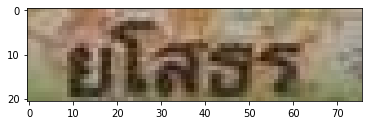

-------------------------------
filenames : 1495.jpg
actual register : อุตรดิตถ์
predict register : ปราจีนบุรี


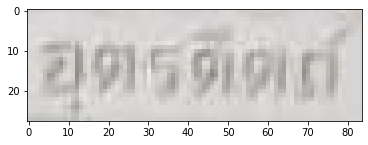

-------------------------------
filenames : 1500.jpg
actual register : อุบลราชธานี
predict register : กรุงเทพมหานคร


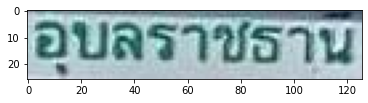

-------------------------------
filenames : 1508.jpg
actual register : นครสวรรค์
predict register : กรุงเทพมหานคร


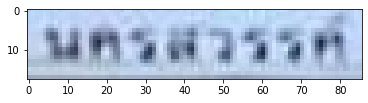

-------------------------------
filenames : 1511.jpg
actual register : กาญจนบุรี
predict register : กำแพงเพชร


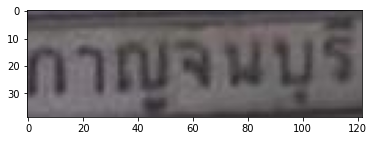

-------------------------------
filenames : 1522.jpg
actual register : อุบลราชธานี
predict register : กรุงเทพมหานคร


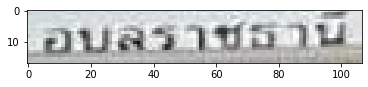

-------------------------------
filenames : 1528.jpg
actual register : อุบลราชธานี
predict register : นครนายก


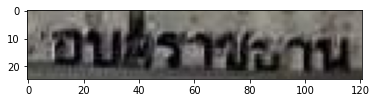

-------------------------------
filenames : 1538.jpg
actual register : อุบลราชธานี
predict register : กรุงเทพมหานคร


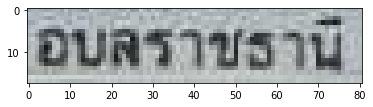

-------------------------------
filenames : 1545.jpg
actual register : ชลบุรี
predict register : นครพนม


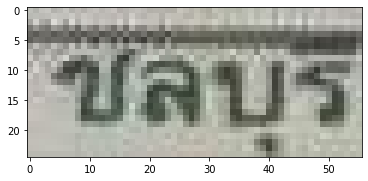

-------------------------------
filenames : 1563.jpg
actual register : สมุทรสาคร
predict register : กรุงเทพมหานคร


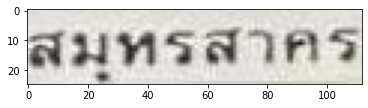

-------------------------------
filenames : 1568.jpg
actual register : อุดรธานี
predict register : อุบลราชธานี


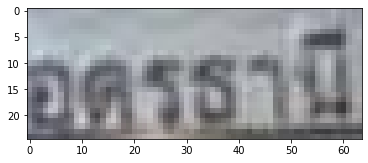

-------------------------------
filenames : 1590.jpg
actual register : ชลบุรี
predict register : ลพบุรี


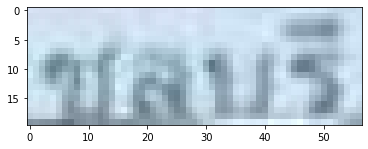

-------------------------------
filenames : 1592.jpg
actual register : ชัยนาท
predict register : อุตรดิตถ์


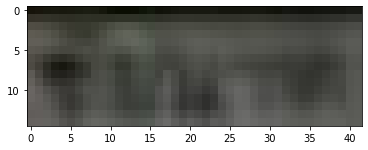

-------------------------------
filenames : 1595.jpg
actual register : เพชรบูรณ์
predict register : มหาสารคาม


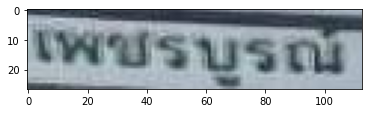

-------------------------------
filenames : 1601.jpg
actual register : เชียงใหม่
predict register : ลำปาง


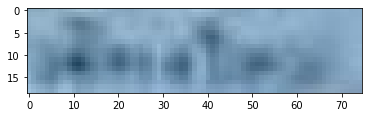

-------------------------------
filenames : 1620.jpg
actual register : นครราชสีมา
predict register : พระนครศรีอยุธยา


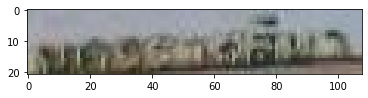

-------------------------------
filenames : 1624.jpg
actual register : อุบลราชธานี
predict register : กรุงเทพมหานคร


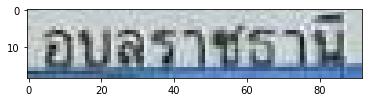

-------------------------------
filenames : 1625.jpg
actual register : อุบลราชธานี
predict register : กรุงเทพมหานคร


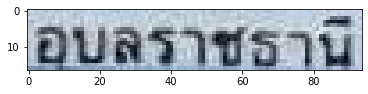

-------------------------------
filenames : 1636.jpg
actual register : พระนครศรีอยุธยา
predict register : กรุงเทพมหานคร


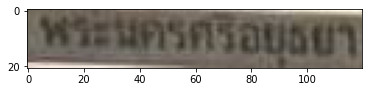

-------------------------------
filenames : 1665.jpg
actual register : นครสวรรค์
predict register : กรุงเทพมหานคร


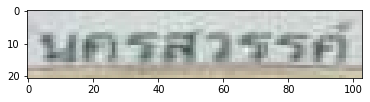

-------------------------------
filenames : 1675.jpg
actual register : บุรีรัมย์
predict register : เลย


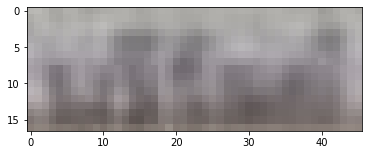

-------------------------------
filenames : 1681.jpg
actual register : ตาก
predict register : กรุงเทพมหานคร


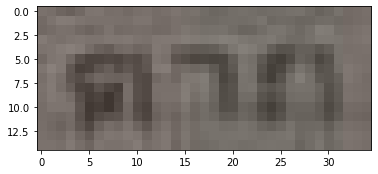

-------------------------------
filenames : 1691.jpg
actual register : มหาสารคาม
predict register : แม่ฮ่องสอน


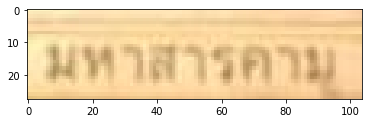

-------------------------------
filenames : 1693.jpg
actual register : อุบลราชธานี
predict register : กรุงเทพมหานคร


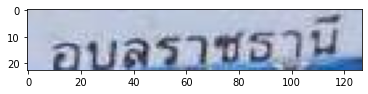

-------------------------------
filenames : 1696.jpg
actual register : อุดรธานี
predict register : กรุงเทพมหานคร


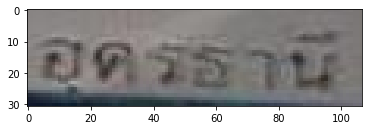

-------------------------------
filenames : 1710.jpg
actual register : มหาสารคาม
predict register : กรุงเทพมหานคร


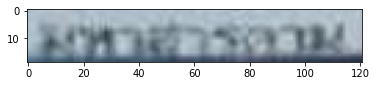

-------------------------------
filenames : 1718.jpg
actual register : ภูเก็ต
predict register : กรุงเทพมหานคร


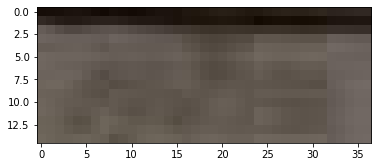

-------------------------------
filenames : 1721.jpg
actual register : ชัยนาท
predict register : กรุงเทพมหานคร


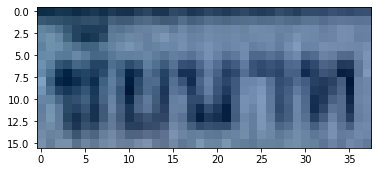

-------------------------------
filenames : 1723.jpg
actual register : มหาสารคาม
predict register : กรุงเทพมหานคร


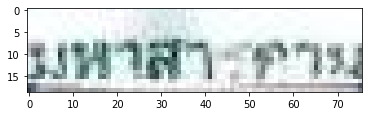

-------------------------------
filenames : 1747.jpg
actual register : นครราชสีมา
predict register : กรุงเทพมหานคร


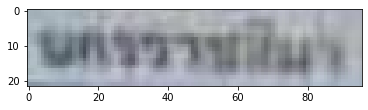

-------------------------------
filenames : 1765.jpg
actual register : ฉะเชิงเทรา
predict register : น่าน


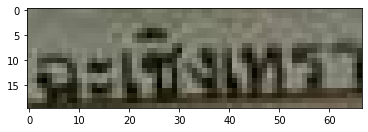

-------------------------------
filenames : 1772.jpg
actual register : ร้อยเอ็ด
predict register : นครราชสีมา


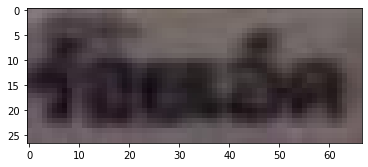

-------------------------------
filenames : 1775.jpg
actual register : nan
predict register : สกลนคร


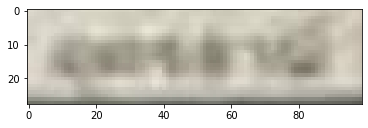

-------------------------------
filenames : 1782.jpg
actual register : นครศรีธรรมราช
predict register : กรุงเทพมหานคร


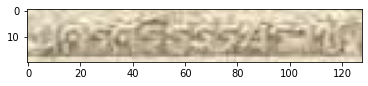

-------------------------------
filenames : 1785.jpg
actual register : พะเยา
predict register : นนทบุรี


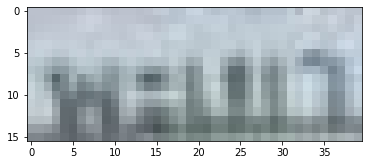

-------------------------------
filenames : 1796.jpg
actual register : กาญจนบุรี
predict register : กรุงเทพมหานคร


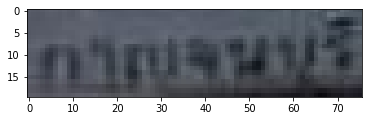

-------------------------------
filenames : 1811.jpg
actual register : สุราษฎร์ธานี
predict register : กรุงเทพมหานคร


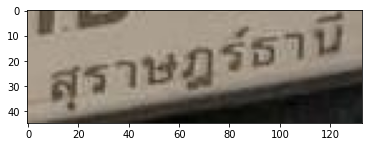

-------------------------------
filenames : 1816.jpg
actual register : ลำพูน
predict register : กาญจนบุรี


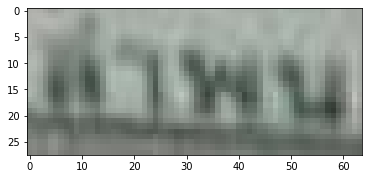

-------------------------------
filenames : 240.jpg
actual register : ชลบุรี
predict register : กระบี่


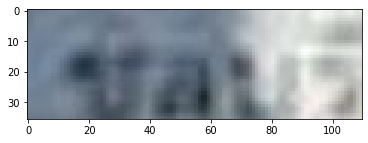

-------------------------------
filenames : 298.jpg
actual register : นครนายก
predict register : กรุงเทพมหานคร


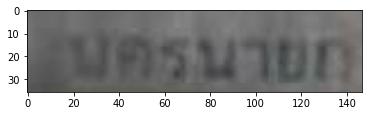

-------------------------------
filenames : 308.jpg
actual register : แพร่
predict register : เเพร่


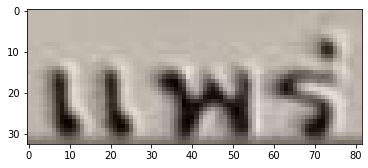

-------------------------------
filenames : 336.jpg
actual register : พังงา
predict register : เบตง


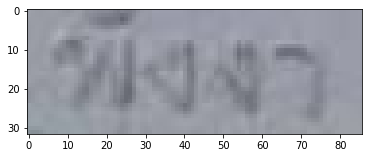

-------------------------------
filenames : 337.jpg
actual register : พังงา
predict register : สงขลา


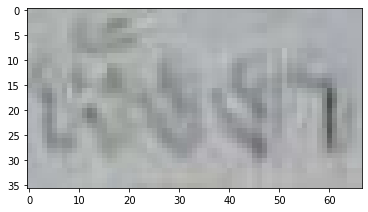

-------------------------------
filenames : 375.jpg
actual register : กาญจนบุรี
predict register : สกลนคร


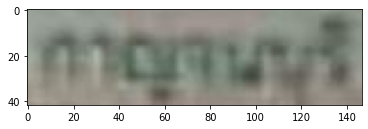

-------------------------------
filenames : 415.jpg
actual register : น่าน
predict register : ลำปาง


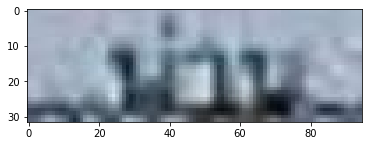

-------------------------------
filenames : 461.jpg
actual register : กาฬสินธุ์
predict register : พระนครศรีอยุธยา


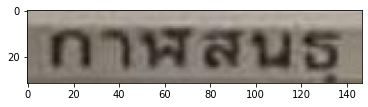

-------------------------------
filenames : 509.jpg
actual register : ชุมพร
predict register : ปทุมธานี


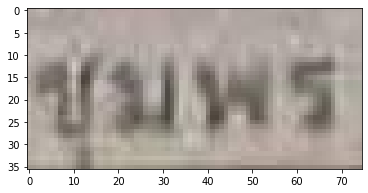

-------------------------------
filenames : 519.jpg
actual register : เพชรบูรณ์
predict register : กรุงเทพมหานคร


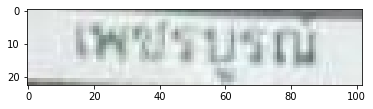

-------------------------------
filenames : 579.jpg
actual register : พิษณุโลก
predict register : อุบลราชธานี


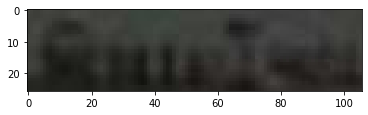

-------------------------------
filenames : 598.jpg
actual register : ขอนแก่น
predict register : สิงห์บุรี


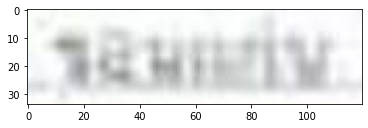

-------------------------------
filenames : 599.jpg
actual register : ขอนแก่น
predict register : กรุงเทพมหานคร


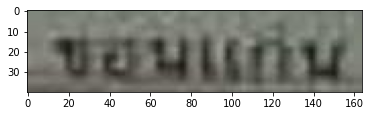

-------------------------------
filenames : 647.jpg
actual register : เชียงใหม่
predict register : มหาสารคาม


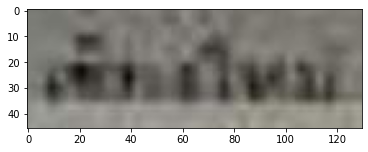

-------------------------------
filenames : 700.jpg
actual register : ชลบุรี
predict register : ลพบุรี


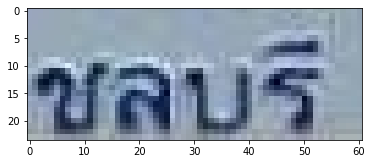

-------------------------------
filenames : 710.jpg
actual register : สุรินทร์
predict register : กรุงเทพมหานคร


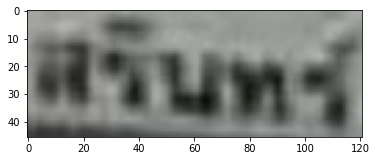

-------------------------------
filenames : 723.jpg
actual register : เพชรบูรณ์
predict register : อุบลราชธานี


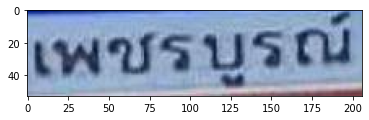

-------------------------------
filenames : 725.jpg
actual register : กรุงเทพมหานคร
predict register : สมุทรสงคราม


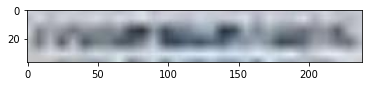

-------------------------------
filenames : 728.jpg
actual register : เพชรบุรี
predict register : กรุงเทพมหานคร


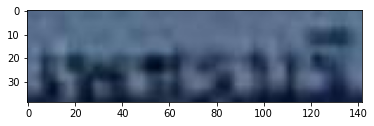

-------------------------------
filenames : 769.jpg
actual register : สุรินทร์
predict register : อุบลราชธานี


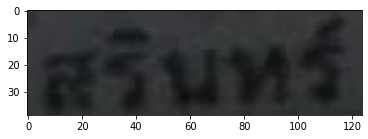

-------------------------------
filenames : 804.jpg
actual register : เพชรบูรณ์
predict register : เพชรบุรี


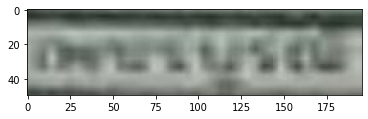

-------------------------------
filenames : 828.jpg
actual register : ระยอง
predict register : กรุงเทพมหานคร


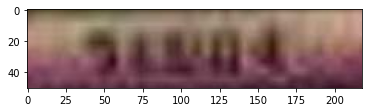

-------------------------------
filenames : 839.jpg
actual register : กาฬสินธุ์
predict register : นราธิวาส


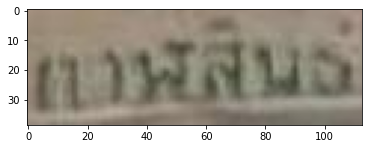

-------------------------------
filenames : 850.jpg
actual register : สุราษฎร์ธานี
predict register : พระนครศรีอยุธยา


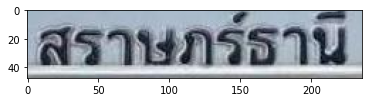

-------------------------------
filenames : 855.jpg
actual register : ชุมพร
predict register : นนทบุรี


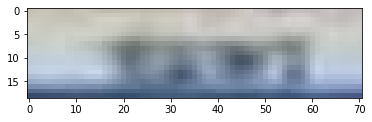

-------------------------------
filenames : 863.jpg
actual register : สระบุรี
predict register : ปัตตานี


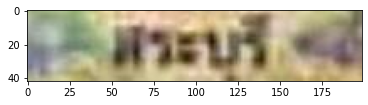

-------------------------------
filenames : 864.jpg
actual register : สระบุรี
predict register : ลพบุรี


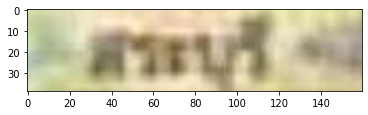

-------------------------------
filenames : 873.jpg
actual register : ระยอง
predict register : กรุงเทพมหานคร


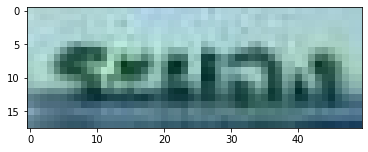

-------------------------------
filenames : 88.jpg
actual register : อุบลราชธานี
predict register : กรุงเทพมหานคร


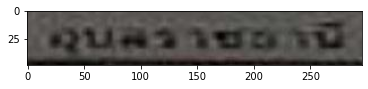

-------------------------------
filenames : 887.jpg
actual register : หนองบัวลำภู
predict register : กรุงเทพมหานคร


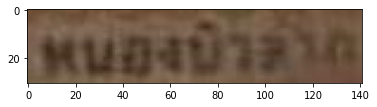

-------------------------------
filenames : 906.jpg
actual register : ชุมพร
predict register : เบตง


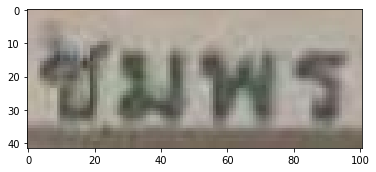

-------------------------------
filenames : 940.jpg
actual register : ระยอง
predict register : ระนอง


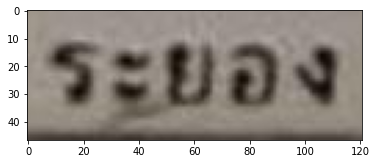

-------------------------------
filenames : 944.jpg
actual register : อุดรธานี
predict register : อุบลราชธานี


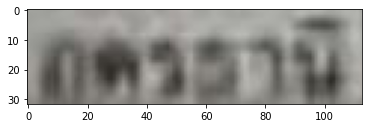

-------------------------------
filenames : 948.jpg
actual register : มหาสารคาม
predict register : กรุงเทพมหานคร


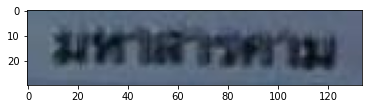

-------------------------------
filenames : 973.jpg
actual register : ฉะเชิงเทรา
predict register : นครศรีธรรมราช


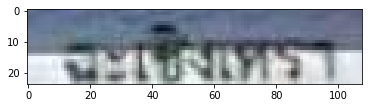

-------------------------------
filenames : 977.jpg
actual register : สุราษฎร์ธานี
predict register : มหาสารคาม


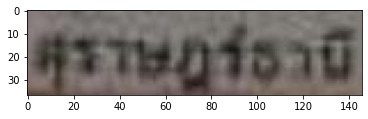

-------------------------------
filenames : 979.jpg
actual register : อำนาจเจริญ
predict register : ตรัง


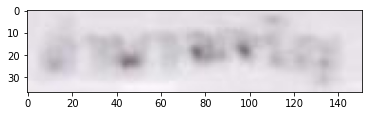

-------------------------------
filenames : 981.jpg
actual register : สุพรรณบุรี
predict register : กรุงเทพมหานคร


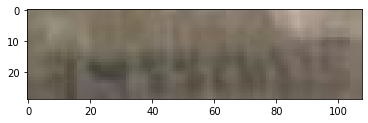

-------------------------------


In [175]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
# results_df['actual register'][0]
# results_df['predict register'][0]
# print(len(results_df))
for k in range(len(df_test)):
    if df_test['actual province'][k] != df_test['predict province'][k]:
        print('filenames :',df_test['filenames'][k])
        print('actual register :', df_test['actual province'][k])
        print('predict register :',df_test['predict province'][k])
        img = Image.open('out/province/'+df_test['filenames'][k])
        imgplot = plt.imshow(img)
        plt.show()
        print('-------------------------------')